In [1]:
%load_ext autoreload
%autoreload 2
# This will reload all modules every time you run a cell
# You may refer to here https://switowski.com/blog/ipython-autoreload/

In [2]:
# import shutil
# shutil.rmtree("./lightning_logs")

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import einops
from pathlib import Path
from pprint import pprint
from torch import optim

from utils import VideoWriter, transform
from display import NCAGrid
from lightning_module import NCALightningModule
from dataset import NCADataModule
from model import Updater, Perceiver, NCA

In [2]:
SEED_CACHE = Path("./seed") # For storing all seed caches
SEED_CACHE_SIZE = 16 # Must be at least the batch_size, to avoid the drop_last, Might not be neccessary tho
BATCH_SIZE = 16
TRAIN_STEP = 56

SEED_CACHE.mkdir(exist_ok=True, parents=True)
GRID_SIZE = (40, 40)
CELL_FIRE_RATE = 0.5
CLIP_VALUE = [-10, 10]
ALIVE_THRESHOLD = 0.1
USE_ALIVE_CHANNEL = True # If False, all cells are assume alive
THUMBNAIL_SIZE = 32 # This controls the size of the target image, must be smaller than grid_size
NUM_HIDDEN_CHANNELS = 18
NUM_STATIC_CHANNELS = 0
NUM_TARGET_CHANNELS = 3
TOTAL_CHANNELS = NUM_HIDDEN_CHANNELS + NUM_STATIC_CHANNELS + NUM_TARGET_CHANNELS + 1

Defining our NCA dataset object, each NCA data in the dataset defines the state of the grid.

Below are the explanation for each arguments:

In [3]:
lit_dm = NCADataModule(
    seed_cache_dir=SEED_CACHE, 
    grid_size=GRID_SIZE, 
    num_hidden_channels=NUM_HIDDEN_CHANNELS, 
    num_target_channels=NUM_TARGET_CHANNELS, 
    num_static_channels=NUM_STATIC_CHANNELS, 
    target_image_path="./pic/32/emoji_u0037_20e3.png",
    batch_size=BATCH_SIZE,
    thumbnail_size=THUMBNAIL_SIZE,
    clear_cache=True
)

Visualizing the target emoji that our NCA has to form.

ValueError: Could not save to JPEG for display

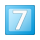

In [4]:
import torchvision.transforms as T

to_pil_func = T.ToPILImage()
img = to_pil_func(lit_dm.dataset.target_image_processed)
img

Defining our NCA module. A NCA model will take in the current grid state provided by the DataModule object and output the next grid state.

Every NCA module will have a `Perceiver` object defining how each individual cell in the grid receive the state information of its neighbouring cells, and an `Updater` object defining how to compute the change in cell state from the data received from `Perceiver`.


Below are the explanation for each of the arguments:



In [5]:
NET_HIDDEN_CHANNELS = 63

In [6]:
perceiver_net = Perceiver(in_channels=TOTAL_CHANNELS, out_channels=NET_HIDDEN_CHANNELS, groups=1)
perceiver_net

Perceiver(
  (model): Conv2d(22, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [7]:
updater_net = Updater(in_channels=NET_HIDDEN_CHANNELS, out_channels=TOTAL_CHANNELS)
updater_net

Updater(
  (out): Sequential(
    (0): Conv2d(63, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 22, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)

In [8]:
nca_2d = NCA(
    num_hidden_channels = NUM_HIDDEN_CHANNELS,
    num_target_channels = NUM_TARGET_CHANNELS,
    num_static_channels = NUM_STATIC_CHANNELS,
    use_alive_channel = USE_ALIVE_CHANNEL,
    perceiver = perceiver_net,
    updater= updater_net,
    cell_fire_rate = CELL_FIRE_RATE,
    clip_value = CLIP_VALUE,
    alive_threshold = ALIVE_THRESHOLD,
)

In [9]:
lit_model = NCALightningModule(
    model = nca_2d,
    train_step = TRAIN_STEP,
    seed_cache_dir = SEED_CACHE,
    seed_cache_size = SEED_CACHE_SIZE
)

In [10]:
lit_model = NCALightningModule.load_from_checkpoint(
    "./tb_logs/lightning_logs/version_11/checkpoints/epoch=395-step=1585.ckpt"
)

After defining our grid and the NCA model, we are ready to train our model.

In [11]:
from lightning_module.callback import get_num_generator, CacheBestSeed, CacheCorruptedSeed, VisualizeBestSeed, VisualizeRun

In [12]:
corrupt_func = transform.create_corrupt_2d_circular(h=GRID_SIZE[0], w=GRID_SIZE[1], radius=5)

In [13]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs")

num_gen = get_num_generator(SEED_CACHE_SIZE)

trainer = pl.Trainer(
    max_epochs=1000,
    reload_dataloaders_every_n_epochs=1, # Since the seed cache is updated every epoch
    callbacks=[
        CacheBestSeed(cache_dir=SEED_CACHE, num_generator=num_gen),
        VisualizeBestSeed(),
        VisualizeRun(interval=30, simulate_step=TRAIN_STEP),
        CacheCorruptedSeed(cache_dir=SEED_CACHE, num_generator=num_gen, loss_threshold=0.15, corrupt_func=corrupt_func)
    ],
    logger=logger,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(lit_model, lit_dm) 


  | Name  | Type    | Params
----------------------------------
0 | model | NCA     | 22.1 K
1 | loss  | MSELoss | 0     
----------------------------------
22.1 K    Trainable params
0         Non-trainable params
22.1 K    Total params
0.089     Total estimated model params size (MB)


Epoch 242:   0%|                                     | 0/4 [00:00<?, ?it/s, loss=0.00706, v_num=12]

In [19]:
torch.cuda.is_available()

False